# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pytz
import time

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

validation_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

#transform to be used to view images: 
#test_transform = transforms.Compose([transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])


# Create training set and define training dataloader
train_data = datasets.CIFAR10("train_dir", train = True, transform=train_transforms, download = True)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Create validation set and define validation dataloader
validation_data = datasets.CIFAR10("validation_dir", train = False, transform=validation_transforms, download = True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=64)

# Create test set and define test dataloader
test_data = datasets.CIFAR10("test_dir", train = False, transform=test_transforms, download = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
# determine shape of images and labels
dataiter=iter(trainloader)
images,labels=next(dataiter)
images.shape,labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

Image size is 3 colour channels times 32 by 32 pixels so: <br>
a) input features for network need to be 3 * 32 * 32 = 3072, and <br>
b) Need to flatten the images so has shape = (batch size, 3072)<br>
<br>
There are ten classes so there will be 10 output nodes therefore the output shape for each batch will be 64,10 i.e. a row for each input and a column for each output node. The loss function will compare outputs and labels therefore the labels shape must be the same????? 

In [4]:
# basic non-convolutional network only: create an inputs tensor by flattening the images tensor
# - this will be applied to each dataset in the training and test code below
inputs = images.view(images.shape[0],-1) #this should create features shape of 64, 3072
inputs.shape

torch.Size([64, 3072])

In [4]:
#view the class to output index dictionary
test_data.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [6]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


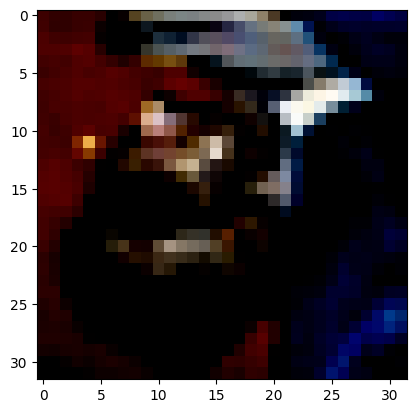

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


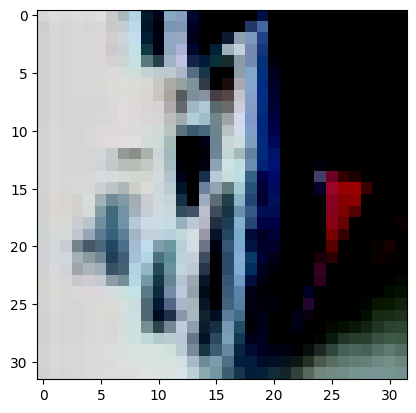

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


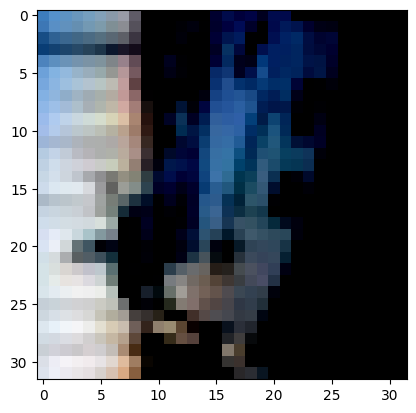

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


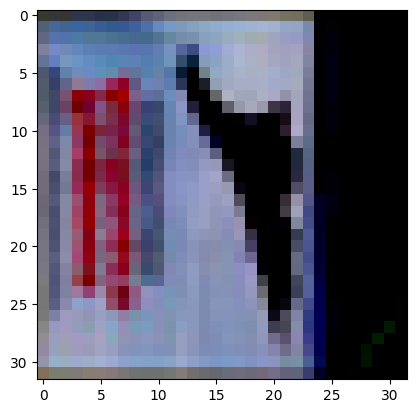

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog


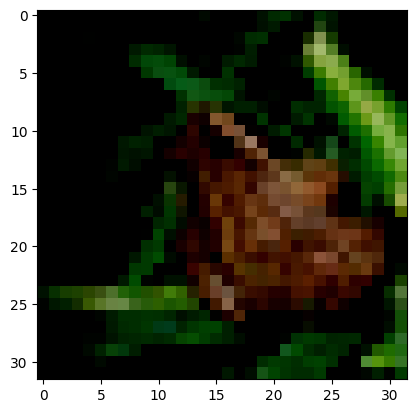

In [7]:
# Explore data
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [17]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Using fc = fully connected so that the following weights and bias initialisation will work
        self.fc1 = nn.Linear(3072, 1024)
        # First hidden layer to second hidden layer linear transformation
        self.fc2 = nn.Linear(1024, 256)
        # Output layer, 10 units - one for each class
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        # First hidden layer with relu activation
        x = self.dropout(F.relu(self.fc1(x)))
        # Second  hidden layer with relu activation
        x = self.dropout(F.relu(self.fc2(x)))
        # Output layer with softmax activation
        x = F.softmax(self.fc3(x), dim=1)
        
        return x

Above model validation accuracy did not rise above 16% so using a convolutional neural network as below. 

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(24, 34, 3)
        self.fc1 = nn.Linear(34 * 6 * 6, 100)
        self.fc2 = nn.Linear(100, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 34 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [11]:
#instantiate the model
model = Net()

#view model to double check number input nodes 
model

Net(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(24, 34, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1224, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [12]:
#define loss function
criterion = nn.NLLLoss()

# define optimiser
optimizer = optim.Adam(model.parameters(), lr=0.003)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [13]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#set Variables for training
epochs = 5
training_steps = 0
training_loss = 0
validate_every = 5 #how often validation is done i.e. every <validate_every> batches

#initialise lists for graphing
running_training_loss = []
running_validation_loss = []
running_validation_accuracy = []

for epoch in range(epochs):
    for images, labels in trainloader:
        start = time.time()
        training_steps += 1
        
        #move image and label to device
        images, labels = images.to(device), labels.to(device)
        
        #change cshape of images so compatible with input layer (basic neural network only)
        #inputs = images.view(images.shape[0],-1)
        
        #perform training steps
        #optimiser gradient will accumulate so set to zero before calculating gradients each time
        optimizer.zero_grad()
        #find probabilities log is used here because output is an exponent (softmax)
        logps = model(images)
        #Calculate loss overall
        loss = criterion(logps, labels)
        #calculate gradients for all parameters
        loss.backward()
        #Update parameters  
        optimizer.step()
        
        training_loss += loss.item()
        
        #perform validation every <validate_every> batches
        if training_steps % validate_every == 0:
            model.eval()
            validation_loss = 0
            accuracy = 0
            
            #disable autograd for validation - gradients do not need to be calculated
            with torch.no_grad():
                #perform validation loop on each batch in the validation loader
                for images, labels in validationloader:

                    #move image and label to device
                    images, labels = images.to(device), labels.to(device)
                    
                    #change cshape of images so compatible with input layer 
                    # (basic neural network only convolutional neural network takes in 3d data)
                    #inputs = images.view(images.shape[0],-1)

                    logps = model(images)
                    loss = criterion(logps, labels) #find the loss for this batch
                    validation_loss += loss.item() #sum losses for all batches

                    #calculate accuracy
                    ps = torch.exp(logps)
                    top_ps, top_class = ps.topk(1, dim = 1)
                    equality = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equality.type(torch.FloatTensor))
            
            running_training_loss.append(training_loss/validate_every)
            running_validation_loss.append(validation_loss/len(validationloader))
            running_validation_accuracy.append(accuracy/len(validationloader))
            
            with open('classifier_results_2.txt', 'a') as f:
                f.write(f"\nDevice = {device} \n \
                Date: {datetime.now(pytz.timezone('Pacific/Auckland'))} \n \
                Time for this batch: {(time.time() - start)/3:.3f} seconds \n \
                Epoch: {epoch + 1}/{epochs} \n \
                Batch: {training_steps}/{len(trainloader)} \n \
                Training Loss: {training_loss/validate_every:.3f} \n \
                Validation Loss: {validation_loss/len(validationloader):.3f} \n \
                Validation Accuracy: {accuracy/len(validationloader):.3f} \n")
            
            print(f"Device = {device} ",
                  f"Time for this batch: {(time.time() - start)/3:.3f} seconds ",
                  f" Epoch: {epoch + 1}/{epochs} ",
                  f" Batch: {training_steps}/{len(trainloader)} ",
                  f"Training Loss: {training_loss/validate_every:.3f} ",
                  f"Validation Loss: {validation_loss/len(validationloader):.3f} ", #divide by number of batches to see average los
                  f"Validation Accuracy: {accuracy/len(validationloader):.3f}") #divide by number of batches to see average accuracy
            
            training_loss = 0
            model.train()

Device = cuda  Time for this batch: 0.834 seconds   Epoch: 1/5   Batch: 5/782  Training Loss: -0.103  Validation Loss: -0.101  Validation Accuracy: 0.104
Device = cuda  Time for this batch: 0.841 seconds   Epoch: 1/5   Batch: 10/782  Training Loss: -0.102  Validation Loss: -0.114  Validation Accuracy: 0.123
Device = cuda  Time for this batch: 0.846 seconds   Epoch: 1/5   Batch: 15/782  Training Loss: -0.114  Validation Loss: -0.126  Validation Accuracy: 0.141
Device = cuda  Time for this batch: 0.863 seconds   Epoch: 1/5   Batch: 20/782  Training Loss: -0.132  Validation Loss: -0.134  Validation Accuracy: 0.150
Device = cuda  Time for this batch: 0.842 seconds   Epoch: 1/5   Batch: 25/782  Training Loss: -0.134  Validation Loss: -0.149  Validation Accuracy: 0.155
Device = cuda  Time for this batch: 0.846 seconds   Epoch: 1/5   Batch: 30/782  Training Loss: -0.168  Validation Loss: -0.155  Validation Accuracy: 0.155
Device = cuda  Time for this batch: 0.835 seconds   Epoch: 1/5   Batch:

Device = cuda  Time for this batch: 0.830 seconds   Epoch: 1/5   Batch: 270/782  Training Loss: -0.192  Validation Loss: -0.188  Validation Accuracy: 0.189
Device = cuda  Time for this batch: 0.825 seconds   Epoch: 1/5   Batch: 275/782  Training Loss: -0.173  Validation Loss: -0.174  Validation Accuracy: 0.174
Device = cuda  Time for this batch: 0.831 seconds   Epoch: 1/5   Batch: 280/782  Training Loss: -0.159  Validation Loss: -0.164  Validation Accuracy: 0.164
Device = cuda  Time for this batch: 0.827 seconds   Epoch: 1/5   Batch: 285/782  Training Loss: -0.147  Validation Loss: -0.157  Validation Accuracy: 0.157
Device = cuda  Time for this batch: 0.836 seconds   Epoch: 1/5   Batch: 290/782  Training Loss: -0.173  Validation Loss: -0.154  Validation Accuracy: 0.154
Device = cuda  Time for this batch: 0.830 seconds   Epoch: 1/5   Batch: 295/782  Training Loss: -0.158  Validation Loss: -0.159  Validation Accuracy: 0.159
Device = cuda  Time for this batch: 0.827 seconds   Epoch: 1/5  

Device = cuda  Time for this batch: 0.859 seconds   Epoch: 1/5   Batch: 535/782  Training Loss: -0.143  Validation Loss: -0.156  Validation Accuracy: 0.156
Device = cuda  Time for this batch: 0.831 seconds   Epoch: 1/5   Batch: 540/782  Training Loss: -0.134  Validation Loss: -0.154  Validation Accuracy: 0.154
Device = cuda  Time for this batch: 0.838 seconds   Epoch: 1/5   Batch: 545/782  Training Loss: -0.168  Validation Loss: -0.157  Validation Accuracy: 0.157
Device = cuda  Time for this batch: 0.830 seconds   Epoch: 1/5   Batch: 550/782  Training Loss: -0.195  Validation Loss: -0.156  Validation Accuracy: 0.156
Device = cuda  Time for this batch: 0.835 seconds   Epoch: 1/5   Batch: 555/782  Training Loss: -0.132  Validation Loss: -0.156  Validation Accuracy: 0.156
Device = cuda  Time for this batch: 0.857 seconds   Epoch: 1/5   Batch: 560/782  Training Loss: -0.131  Validation Loss: -0.159  Validation Accuracy: 0.159
Device = cuda  Time for this batch: 0.857 seconds   Epoch: 1/5  

KeyboardInterrupt: 

Plot the training loss (and validation loss/accuracy, if recorded).

In [ ]:
import matplotlib.pyplot as plt

# Set graph size
plt.figure(figsize=(8, 4))
x = range(1, len(running_validation_accuracy) + 1)
y = running_validation_accuracy
plt.plot(x, y)
# Label the axes
plt.ylabel('Validation accuracy')
plt.xlabel('Batch')
plt.title('Validation accuracy during training')
# Dsiplay the plot
plt.show()

# Set graph size
plt.figure(figsize=(8, 4))
x = range(1, len(running_training_loss) + 1)
y = running_training_loss
plt.plot(x, y, label = "Training loss")
x = range(1, len(running_validation_loss) + 1)
y = running_validation_loss
plt.plot(x, y, label = "Validation loss")
# Label the axes
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.title('Losses during training')
plt.legend(frameon=False)
# Dsiplay the plot
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
# TODO: Do validation on the test set
test_loss = 0
accuracy = 0
testing_steps = 0

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.NLLLoss()
model.eval()

with torch.no_grad():
    #perform validation loop on each batch in the validation loader
    for images, labels in testloader:
        testing_steps += 1
        
        #move image and label to device
        images, labels = images.to(device), labels.to(device)
        #change shape of images so compatible with input layer
        inputs = images.view(images.shape[0],-1)

        logps = model(inputs)
        loss = criterion(logps, labels) #find the loss for this batch
        test_loss += loss.item() #sum losses for all batches

        #calculate accuracy for each batch
        ps = torch.exp(logps)
        top_ps, top_class = ps.topk(1, dim = 1)
        equality = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equality.type(torch.FloatTensor))
        
        print(f"Test batch: {testing_steps}/{len(testloader)} ",
              f"Test loss: {test_loss/testing_steps:.3f} ", #divide by number of test batches to see average test loss
              f"Test accuracy: {accuracy/testing_steps:.3f}") #divide by number of test batches to see average test accuracy


## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
#add the class to indices map
model.class_to_idx = train_data.class_to_idx

#check mapping has been added
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

checkpoint = {'class_to_idx': model.class_to_idx,
              'state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),         
             }

torch.save(checkpoint, 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Definitely buy as 15% accuracy is not much better than guessing!
